# Business Problem

One of the global banks would like to understand what factors driving credit card spend are. The bank want use these insights to calculate credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data.

The objective of this case study is to understand what's driving the total spend (Primary Card + Secondary card). Given the factors, predict credit limit for the new applicants


## Data Availability:

1.) Data for the case are available in xlsx format.

2.) The data have been provided for 5000 customers.

3.) Detailed data dictionary has been provided for understanding the data in the data.

4.) Data is encoded in the numerical format to reduce the size of the data however some of the variables are categorical. You    can find the details in the data dictionary


### import the packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
import scipy.stats as stats
import sklearn as sk
import statsmodels as sm
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams['axes.grid'] = True

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf

In [4]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('mode.chained_assignment', None) # For SettingWithCopyWarning

In [5]:
data = pd.read_excel('data set.xlsx')

In [6]:
data.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [7]:
data.shape

(5000, 130)

In [8]:
data['Total_Spend'] = data.cardspent + data.card2spent
data.drop(['cardspent', 'card2spent'], axis = 1, inplace = True)

### Exporting pandas profiling output to html file

In [9]:
# report = pandas_profiling.ProfileReport(data)

In [10]:
# report.to_file(output_file = 'profilereport.html')

### Basic Exploratory Analysis

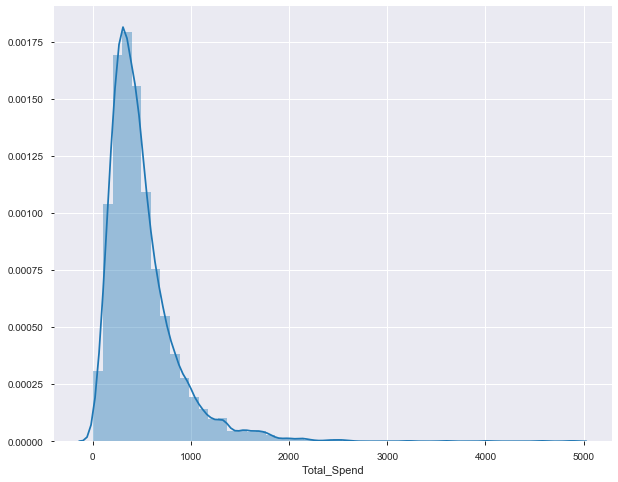

In [11]:
sns.distplot(data.Total_Spend)
plt.show()

In [12]:
data['Log_total_spend'] = np.log(data['Total_Spend'])

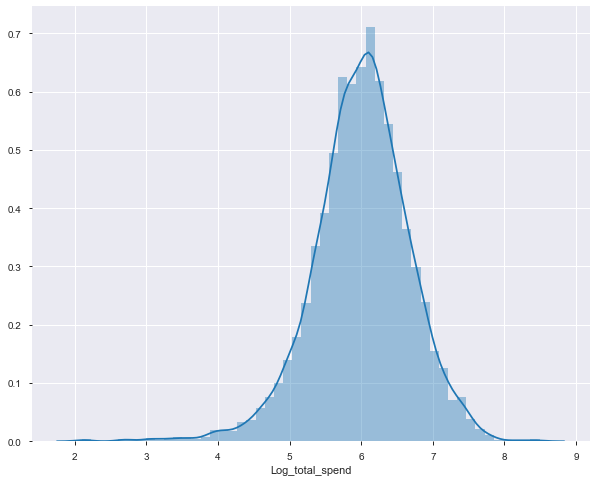

In [13]:
sns.distplot(data.Log_total_spend)
plt.show()

In [14]:
# Linearity: correlation matrix (ranges from 1 to -1)
corrm = data.corr()
corrm.to_csv('PCC_corrm.csv')

In [15]:
numeric_vars_name = [key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['int16', 'int64', 'float16', 'float64']]
cat_vars_name = [key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['object', 'O']]

In [16]:
# numeric_vars_name

In [17]:
cat_vars_name  # birthmonth is not usefull in prediction so we don't use birthmonth

['custid', 'birthmonth']

In [18]:
data_num = data[numeric_vars_name]
data_num.head()

,region,townsize,gender,age,agecat,ed,edcat,jobcat,union,employ,...,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Total_Spend,Log_total_spend
0,1,2.0,1,20,2,15,3,1,1,0,...,0,1,1,0,0,0,1,0,149.46,5.007029
1,5,5.0,0,22,2,17,4,2,0,0,...,1,1,1,1,1,0,0,0,77.54,4.350794
2,3,4.0,1,67,6,14,2,2,0,16,...,0,0,0,0,1,0,0,0,359.97,5.886021
3,4,3.0,0,23,2,16,3,2,0,0,...,1,1,1,0,1,1,0,0,359.41,5.884464
4,2,2.0,0,26,3,16,3,2,0,1,...,1,0,1,0,0,0,1,0,507.83,6.230147


### Data Audit Report

In [19]:
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(), x.std(), x.var(), x.min(),
                     x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), x.quantile(0.25), x.quantile(0.50), 
                     x.quantile(0.75), x.quantile(0.95), x.quantile(0.99), x.max()],
                
            index = ['N', 'NMISS', 'SUM', 'MEAN', 'MEDIAN', 'STD', 'VAR', 'MIN', 
                     'P1', 'P5', 'P10', 'P25', 'P50', 'P75', 'P95', 'P99', 'MAX'])

In [20]:
data_num.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P95,P99,MAX
region,5000.0,0.0,1.500700e+04,3.001400,3.00000,1.421760,2.021402,1.000000,1.000000,1.000000,1.000000,2.000000,3.00000,4.000000,5.000000,5.000000,5.000000
townsize,4998.0,2.0,1.343100e+04,2.687275,3.00000,1.425925,2.033262,1.000000,1.000000,1.000000,1.000000,1.000000,3.00000,4.000000,5.000000,5.000000,5.000000
gender,5000.0,0.0,2.518000e+03,0.503600,1.00000,0.500037,0.250037,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000
age,5000.0,0.0,2.351280e+05,47.025600,47.00000,17.770338,315.784902,18.000000,18.000000,20.000000,23.000000,31.000000,47.00000,62.000000,76.000000,79.000000,79.000000
agecat,5000.0,0.0,2.119400e+04,4.238800,4.00000,1.308785,1.712917,2.000000,2.000000,2.000000,2.000000,3.000000,4.00000,5.000000,6.000000,6.000000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
response_01,5000.0,0.0,4.180000e+02,0.083600,0.00000,0.276815,0.076626,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000
response_02,5000.0,0.0,6.490000e+02,0.129800,0.00000,0.336117,0.112975,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000
response_03,5000.0,0.0,5.130000e+02,0.102600,0.00000,0.303466,0.092092,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000
Total_Spend,5000.0,0.0,2.490393e+06,498.078630,414.25000,351.529270,123572.827720,8.110000,58.197600,133.106000,184.033000,276.282500,414.25000,615.562500,1145.146500,1760.102400,4881.050000


In [21]:
num_var_summary = data_num.apply(continuous_var_summary).T
num_var_summary.to_csv('num_var_summary.csv')

### Outlier Treatment

In [22]:
data_num = data_num.apply(lambda x : x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

### Missing Value Treatment

In [23]:
def missing_imputation(x):
    return x.fillna(x.median())

In [24]:
data_num = data_num.apply(missing_imputation)

In [25]:
data_num.head()

,region,townsize,gender,age,agecat,ed,edcat,jobcat,union,employ,...,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Total_Spend,Log_total_spend
0,1,2.0,1,20,2,15,3,1,1,0,...,0,1,1,0,0,0,1,0,149.46,5.007029
1,5,5.0,0,22,2,17,4,2,0,0,...,1,1,1,1,1,0,0,0,77.54,4.350794
2,3,4.0,1,67,6,14,2,2,0,16,...,0,0,0,0,1,0,0,0,359.97,5.886021
3,4,3.0,0,23,2,16,3,2,0,0,...,1,1,1,0,1,1,0,0,359.41,5.884464
4,2,2.0,0,26,3,16,3,2,0,1,...,1,0,1,0,0,0,1,0,507.83,6.230147


In [26]:
new_data = data_num
corrm = new_data.corr()
# corrm.to_csv("corrm.csv")

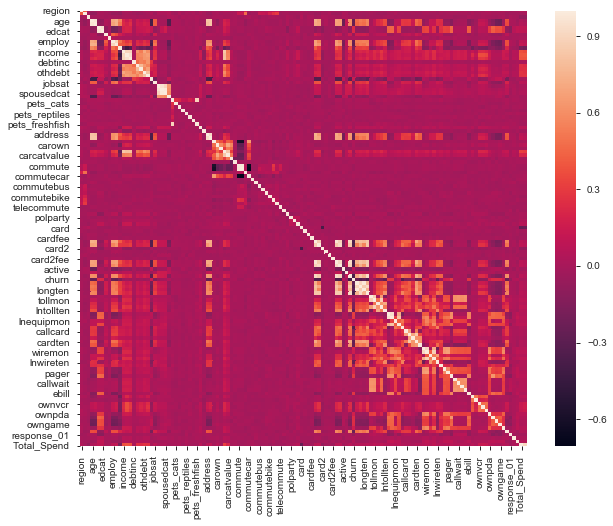

In [27]:
sns.heatmap(corrm)
plt.show()

### Droping Variables

In [28]:
# Droping variable which have high missing and not-usefull for prediction 

data_num.drop(columns = ['pets_birds', 'pets_cats', 'pets_dogs', 'pets_freshfish', 'pets_reptiles', 'pets_saltfish', 'pets_small'],
                 axis = 1, 
              inplace = True)

In [29]:
# Droping duplicate 

data_num.drop(columns = ['cardtenurecat', 'card2tenurecat'], axis = 1, inplace = True)

In [30]:
# Droping duplicate values like log values

data_num.drop(columns = ['lninc', 'lncreddebt', 'lnothdebt', 'lnlongten', 'lnlongmon', 'lntollmon', 'lntollten', 
                         'lnequipten', 'lnequipmon', 'lncardmon', 'lncardten', 'lnwiremon', 'lnwireten'],
                 axis = 1,
              inplace = True)

In [31]:
# Droping variable which have low variance and not-usefull for prediction

data_num.drop(columns = ['commutepublic', 'commutemotorcycle', 'commutenonmotor'], axis = 1, inplace = True)

### Feature Selection Based on Univariate ANOVA Test

In [32]:
features = data_num[data_num.columns.difference(['Total_Spend', 'Log_total_spend'])]

In [33]:
target = data_num.Log_total_spend

In [34]:
# a = f_regression(features, target)
# f_values, p_values = a

In [35]:
f_values, p_values = f_regression(features, target)

In [36]:
p_values = ['%.3f' % p for p in p_values]

In [37]:
result = pd.DataFrame([features.columns, (f_values), (p_values)]).T
result = result.rename(columns = {0: 'Variable', 1 : 'F_Value', 2 : 'P_Value'})

In [38]:
result.head()

,Variable,F_Value,P_Value
0,active,0.0991402,0.753
1,address,11.3551,0.001
2,addresscat,27.8868,0.000
3,age,0.264185,0.607
4,agecat,4.56025,0.033


In [39]:
result.dtypes

Variable    object
F_Value     object
P_Value     object
dtype: object

In [40]:
result.P_Value = pd.to_numeric(result.P_Value)
result.sort_values(by =['P_Value'], inplace = True)
new_result = result[result.P_Value <= 0.05]
new_data = new_data[new_result.Variable]

In [41]:
new_data.shape

(5000, 62)

In [42]:
features.shape

(5000, 101)

### Variable Reduction Using RFE (Recursive Feature Elimination)

In [43]:
rfe = RFE(LinearRegression(), 20).fit(new_data, target)
rfe.ranking_

array([22, 18, 10, 30, 38, 19, 20, 43, 21,  1,  1,  1, 23,  1,  6,  5, 29,
        1,  1, 15,  1,  1,  1,  1,  1, 36, 16, 35, 41, 28,  1,  1,  3, 40,
       34,  9,  1, 32,  8,  4,  1,  1, 24, 12,  1,  1, 25,  2, 26, 11, 17,
        7, 13, 33, 39,  1,  1, 14, 37, 31, 42, 27])

In [44]:
a = pd.DataFrame({'Features' : list(new_data.columns),
              'Ranking'  : rfe.ranking_})
ranked_rfe = a.sort_values(by = 'Ranking')
ranked_rfe[ranked_rfe.Ranking == 1]

,Features,Ranking
30,wireless,1
22,pager,1
18,ownfax,1
17,owndvd,1
23,response_03,1
24,retire,1
13,internet,1
45,multline,1
11,inccat,1
20,owntv,1


In [45]:
new_data.columns[rfe.support_]

Index(['gender', 'homeown', 'inccat', 'internet', 'owndvd', 'ownfax', 'owntv',
       'ownvcr', 'pager', 'response_03', 'retire', 'wireless', 'owncd', 'card',
       'addresscat', 'card2', 'voice', 'multline', 'polcontrib', 'ebill'],
      dtype='object')

### Variable Reduction Using Select K-Best Technique

In [46]:
rfe_features = new_data[new_data.columns[rfe.support_]]

In [47]:
k_best = SelectKBest(f_regression, k = 20).fit(new_data, target)

In [48]:
b = pd.DataFrame({'Features' : new_data.columns,
                  'Scores'   : k_best.scores_})
b.sort_values(by = 'Scores', ascending = False)[:20]

,Features,Scores
11,inccat,850.969528
12,income,724.662079
42,carvalue,519.265491
16,othdebt,363.647212
36,card,298.331858
15,creddebt,287.876986
35,carcatvalue,223.075088
24,retire,204.476977
17,owndvd,138.282716
21,ownvcr,125.995381


In [49]:
new_data.columns[k_best.get_support()]

Index(['ed', 'edcat', 'empcat', 'equipten', 'wiremon', 'gender', 'inccat',
       'income', 'creddebt', 'othdebt', 'owndvd', 'owntv', 'ownvcr', 'retire',
       'tollten', 'owncd', 'wireten', 'carcatvalue', 'card', 'carvalue'],
      dtype='object')

### Applying VIF (Variance Inflation Factor)

In [50]:
prams = 'Log_total_spend ~ ' + ' + '.join(new_data)
prams

'Log_total_spend ~ forward + ed + edcat + empcat + employ + equip + equipmon + equipten + wiremon + gender + homeown + inccat + income + internet + jobsat + creddebt + othdebt + owndvd + ownfax + ownpda + owntv + ownvcr + pager + response_03 + retire + tenure + tollfree + tollmon + tollten + vote + wireless + owncd + confer + wireten + card2tenure + carcatvalue + card + cardtenure + carown + callid + addresscat + card2 + carvalue + callwait + voice + multline + address + ownpc + hourstv + owngame + ownipod + region + spousedcat + longmon + longten + polcontrib + ebill + spoused + agecat + news + cardten + bfast'

In [51]:
k_best_feature = new_data[new_data.columns[k_best.get_support()]]

In [52]:
data_new = pd.concat([k_best_feature,rfe_features], axis = 1)

In [53]:
data_new = data_new.loc[:,~data_new.columns.duplicated()]

In [54]:
new_data['Log_total_spend'] = data.Log_total_spend

In [55]:
# separate the Y and X variables
y, X = dmatrices(prams, new_data, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Features,VIF Factor
0,Intercept,246.009461
1,forward,2.158445
2,ed,16.112098
3,edcat,15.446530
4,empcat,7.624686
...,...,...
58,spoused,33.738153
59,agecat,5.107335
60,news,1.602607
61,cardten,2.531102


### Apply Transformation On Numeric Variables

Apply transformation on numeric variables(log, sqrt, square, exp) and identify which transformation gives you best correlation between dependent and independent variables.

In [56]:
trans_data = new_data.Log_total_spend
def check_correlation(x):
    a = trans_data.corr(x)
    b = trans_data.corr(np.log(x+1))
    c = trans_data.corr(np.sqrt(x))
    d = trans_data.corr(np.square(x))
    f = trans_data.corr(np.cbrt(x))
    return pd.Series([a, b, c, d, f], index = ['x','log x','sqrt x','square x','cbrt x'])
    
correlation = new_data.apply(check_correlation).T
correlation.to_csv('correlation.csv')

C:\Users\rahul\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rahul\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [57]:
final_data = pd.DataFrame()

#### log transformation

In [58]:
final_data['log_empcat'] = new_data['empcat'].apply(lambda x:np.log(x+1))
final_data['log_employ'] = new_data['employ'].apply(lambda x:np.log(x+1))
final_data['log_income'] = new_data['income'].apply(lambda x:np.log(x+1))
final_data['log_othdebt'] = new_data['othdebt'].apply(lambda x:np.log(x+1))
final_data['log_forward'] = new_data['forward'].apply(lambda x:np.log(x+1))
final_data['log_equip'] = new_data['equip'].apply(lambda x:np.log(x+1))
final_data['log_gender'] = new_data['gender'].apply(lambda x:np.log(x+1))
final_data['log_homeown'] = new_data['homeown'].apply(lambda x:np.log(x+1))
final_data['log_tenure'] = new_data['tenure'].apply(lambda x:np.log(x+1))
final_data['log_card'] = new_data['card'].apply(lambda x:np.log(x+1))
final_data['log_card2'] = new_data['card2'].apply(lambda x:np.log(x+1))
final_data['log_cardtenure'] = new_data['cardtenure'].apply(lambda x:np.log(x+1))
final_data['log_addresscat'] = new_data['addresscat'].apply(lambda x:np.log(x+1))
final_data['log_callwait'] = new_data['callwait'].apply(lambda x:np.log(x+1))
final_data['log_multline'] = new_data['multline'].apply(lambda x:np.log(x+1))
final_data['log_address'] = new_data['address'].apply(lambda x:np.log(x+1))
final_data['log_ownpc'] = new_data['ownpc'].apply(lambda x:np.log(x+1))
final_data['log_hourstv'] = new_data['hourstv'].apply(lambda x:np.log(x+1))
final_data['log_longmon'] = new_data['longmon'].apply(lambda x:np.log(x+1))
final_data['log_longten'] = new_data['longten'].apply(lambda x:np.log(x+1))
final_data['log_ebill'] = new_data['ebill'].apply(lambda x:np.log(x+1))
final_data['log_agecat'] = new_data['agecat'].apply(lambda x:np.log(x+1))
final_data['log_news'] = new_data['news'].apply(lambda x:np.log(x+1))
final_data['log_card2tenure'] = new_data['card2tenure'].apply(lambda x:np.log(x+1))
final_data['log_pager'] = new_data['pager'].apply(lambda x:np.log(x+1))

#### sqrt transformation

In [59]:
final_data['sqrt_inccat'] = new_data['inccat'].apply(lambda x:np.sqrt(x))
final_data['sqrt_jobsat'] = new_data['jobsat'].apply(lambda x:np.sqrt(x))
final_data['sqrt_carcatvalue'] = new_data['carcatvalue'].apply(lambda x:np.sqrt(x))
final_data['sqrt_carown'] = new_data['carown'].apply(lambda x:np.sqrt(x))
final_data['sqrt_spoused'] = new_data['spoused'].apply(lambda x:np.sqrt(x))
final_data['sqrt_cardten'] = new_data['cardten'].apply(lambda x:np.sqrt(x))
final_data['sqrt_spousedcat'] = new_data['spousedcat'].apply(lambda x:np.sqrt(x))
final_data['sqrt_carvalue'] = new_data['carvalue'].apply(lambda x:np.sqrt(x))

#### square transformation

In [60]:
final_data['square_equipmon'] = new_data['equipmon'].apply(lambda x:np.square(x))
final_data['square_equipten'] = new_data['equipten'].apply(lambda x:np.square(x))
final_data['square_internet'] = new_data['internet'].apply(lambda x:np.square(x))
final_data['square_bfast'] = new_data['bfast'].apply(lambda x:np.square(x))
final_data['square_tollmon'] = new_data['tollmon'].apply(lambda x:np.square(x))

#### exp transformation

In [61]:
final_data['exp_creddebt'] = new_data['creddebt'].apply(lambda x:np.cbrt(x))
final_data['exp_region'] = new_data['region'].apply(lambda x:np.cbrt(x))

In [62]:
final_data = pd.concat([final_data, new_data[['ed', 'edcat', 'wiremon', 'owndvd', 'ownfax', 'ownpda', 'owntv', 
                                'ownvcr', 'response_03', 'retire', 'tollfree', 'vote', 'wireless', 'owncd', 'confer',
                                'wireten', 'callid', 'voice', 'owngame', 'ownipod',
                                'polcontrib', 'Log_total_spend']]], axis = 1)

## Building Linear Regression Model

In [63]:
# divide the data into training and testing and separate out Y and X variables
train, test = train_test_split( final_data,test_size = 0.3,random_state = 598 )

In [64]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  3500  |  No of obs in testing:  1500


In [65]:
lm = smf.ols('''Log_total_spend ~ log_empcat + log_employ + log_income + log_othdebt + log_forward + log_equip + 
                log_gender + log_homeown + log_tenure + log_card + log_card2 + log_cardtenure + log_addresscat + 
                log_callwait + log_multline + log_address + log_ownpc + log_hourstv + log_longmon + log_longten + 
                log_ebill + log_agecat + log_news + log_card2tenure + log_pager + square_equipmon + square_equipten + 
                square_internet + square_bfast + square_tollmon + sqrt_inccat + sqrt_jobsat + sqrt_carcatvalue + 
                sqrt_carown + sqrt_spoused + sqrt_cardten + sqrt_spousedcat + sqrt_carvalue + exp_creddebt + 
                exp_region + ed + edcat + wiremon + owndvd + ownfax + ownpda + owntv + ownvcr +
                response_03 + retire + tollfree + vote + wireless + owncd + confer + wireten + callid + voice +
                owngame + ownipod + polcontrib''', train).fit()

In [66]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        Log_total_spend   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     11.16
Date:                Tue, 28 Jan 2020   Prob (F-statistic):           2.59e-83
Time:                        22:33:12   Log-Likelihood:                -1247.4
No. Observations:                1494   AIC:                             2619.
Df Residuals:                    1432   BIC:                             2948.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.8776      0.421  

In [67]:
# final features after feature selection
lm = smf.ols('''Log_total_spend ~ log_income + log_gender + log_card + log_card2 + log_cardtenure + log_longten +  
                square_internet + sqrt_carcatvalue + sqrt_spoused + sqrt_spousedcat + wiremon + ownfax + ownvcr +
                owncd + wireten  ''', train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        Log_total_spend   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     43.41
Date:                Tue, 28 Jan 2020   Prob (F-statistic):          7.90e-106
Time:                        22:33:12   Log-Likelihood:                -1265.2
No. Observations:                1494   AIC:                             2562.
Df Residuals:                    1478   BIC:                             2647.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.6312      0.265  

In [68]:
# actual spend of training and testing/validation data
pd.set_option('mode.chained_assignment', None)
train['actual_spend'] = (train.Log_total_spend)
test['actual_spend'] = (test.Log_total_spend)

In [69]:
# predict spend on the training and testing/validation data
train['pred_spend'] = (lm.predict(train))
test['pred_spend'] = (lm.predict(test))

In [70]:
# accuracy metrics (MAPE: Mean Absolute Percentage Error)
MAPE_train = np.mean(np.abs(train['actual_spend'] - train['pred_spend']) / train['actual_spend'])
MAPE_test = np.mean(np.abs(test['actual_spend'] - test['pred_spend']) / test['actual_spend'])

print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.07632436867284952  |  MAPE of testing data:  0.07647381543068255


In [71]:
# RMSE (root mean square error)
MSE = np.mean((train.pred_spend - train.actual_spend)**2)
RMSE = np.sqrt(MSE / train.pred_spend.shape[0])

print(' Mean Square Error ', MSE,'\n','Root Mean Square Error: ', RMSE)

 Mean Square Error  104330.15577376807 
 Root Mean Square Error:  5.4597267271688885


In [72]:
# sum of square of resideals
SSR = np.sum((train.pred_spend - train.actual_spend)**2)   

# total sum of squares
SST = np.sum((train.actual_spend - np.mean(train.actual_spend))**2) 

# R2 Score
R2_score = 1 - (SSR / SST)

print('R2 Score: ', R2_score)

R2 Score:  0.651568728611742


### Decile Analysis 

In [73]:
# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_spend'], 10, labels = False)
test['Deciles'] = pd.qcut(test['pred_spend'], 10, labels = False)

In [74]:
# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'pred_spend']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = train[['Deciles', 'actual_spend']].groupby(train.Deciles).mean().sort_index(ascending = False)['actual_spend']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'pred_spend']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = test[['Deciles', 'actual_spend']].groupby(test.Deciles).mean().sort_index(ascending = False)['actual_spend']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# write the data into the file
Decile_analysis_train.to_csv('Decile_analysis_train.csv')
Decile_analysis_test.to_csv('Decile_analysis_test.csv')

In [75]:
Decile_analysis_train

,Deciles,pred_spend,actual_spend
0,9.0,817.087579,959.708467
1,8.0,603.286451,677.812752
2,7.0,526.417051,619.034362
3,6.0,469.918008,568.595733
4,5.0,425.772255,445.307919
5,4.0,386.813116,424.687517
6,3.0,350.392977,393.895000
7,2.0,311.415236,373.325638
8,1.0,274.139969,318.069799
9,0.0,221.014311,281.151600


In [76]:
Decile_analysis_test

,Deciles,pred_spend,actual_spend
0,9.0,826.134185,846.205970
1,8.0,620.575962,680.877612
2,7.0,525.780137,621.231364
3,6.0,459.781083,594.067463
4,5.0,413.125372,440.615909
5,4.0,374.806136,427.861493
6,3.0,342.121170,387.727313
7,2.0,305.437379,395.278485
8,1.0,268.349015,330.039254
9,0.0,200.335512,257.004179


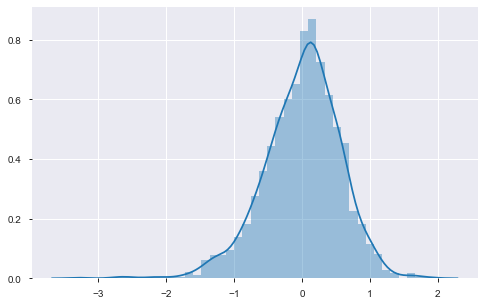

In [77]:
# check Normality of the residuals/error (using distplot)
plt.figure(figsize = (8, 5))
sns.distplot(lm.resid)
plt.show()

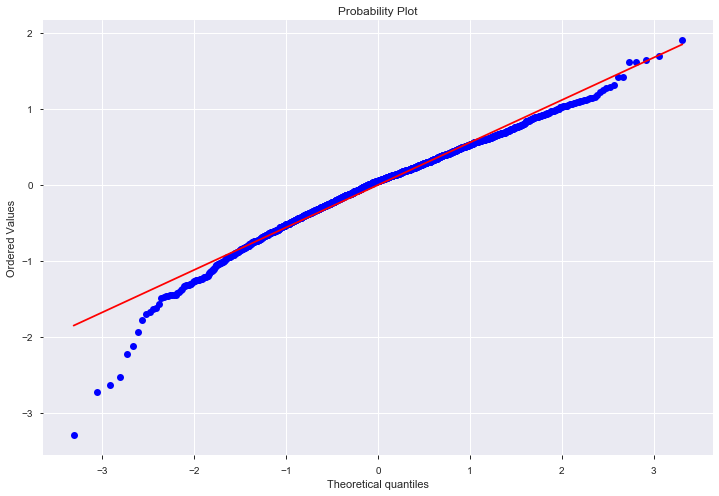

In [78]:
# check Normality of the residuals/error (using Q-Q plot)
from scipy import stats
import pylab
plt.figure(figsize = (12, 8))
stats.probplot(lm.resid, dist = 'norm', plot = pylab)
pylab.show()

If errors are normally and randomly distributed, they would be following a straight line pattern                               
Q-Q plot shows if the residuals are plotted along the line

In [79]:
# check mean of residuals/errors is zero or not
print(lm.resid.mean())

1.590461215056401e-12


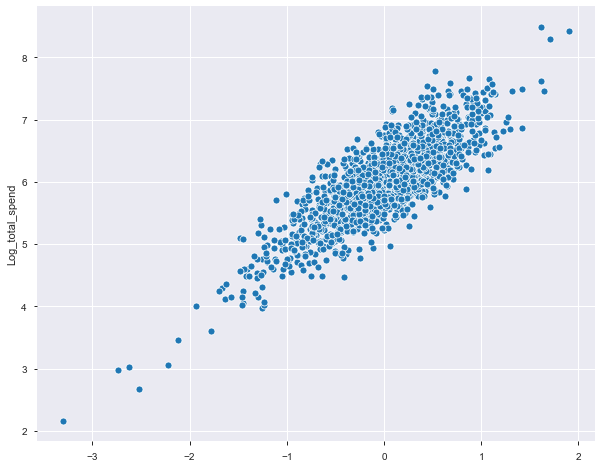

In [80]:
# check homoscedasticity of residuals/errors
sns.scatterplot(lm.resid, train.Log_total_spend)
plt.show()

## Decision Tree (DT)

In [81]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict

In [82]:
data_num.columns

Index(['region', 'townsize', 'gender', 'age', 'agecat', 'ed', 'edcat',
       'jobcat', 'union', 'employ',
       ...
       'ownpc', 'ownipod', 'owngame', 'ownfax', 'news', 'response_01',
       'response_02', 'response_03', 'Total_Spend', 'Log_total_spend'],
      dtype='object', length=103)

In [83]:
feature_columns = data_num[data_num.columns.difference(['Total_Spend', 'Log_total_spend'])]
target = data_num['Log_total_spend']

In [84]:
train_X, test_X, train_Y, test_Y = train_test_split(feature_columns, target, test_size = 0.3, random_state = 8945)

In [85]:
treereg = DecisionTreeRegressor(max_depth = 10, random_state = 1)
treereg.fit(train_X, train_X)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [86]:
scores = cross_val_score(treereg, train_X, train_Y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.6685352209497383

In [87]:
# list of values to try
max_depth_range = range(2, 8)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []


for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=345)
    
    MSE_scores = cross_val_score(treereg, train_X, train_Y, cv=14, scoring='neg_mean_squared_error',verbose=0)
    
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [88]:
print(RMSE_scores)

[0.5693694092535571, 0.5498127699079902, 0.5416732029234671, 0.5525239098531445, 0.5729230810230808, 0.5929148312566925]


Text(0, 0.5, 'RMSE (lower is better)')

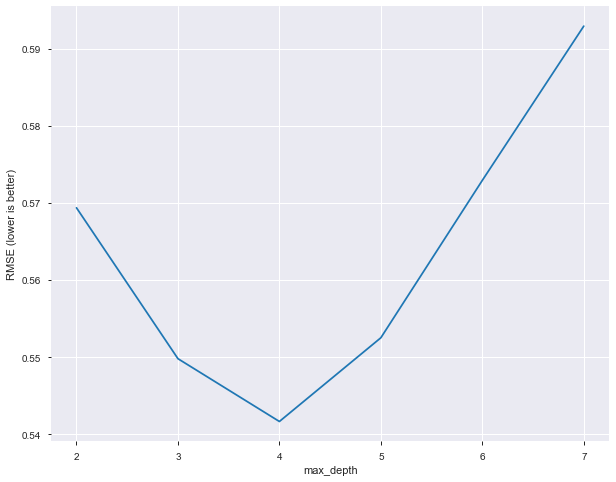

In [89]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

### Final Decision Tree Model

In [90]:
treereg = DecisionTreeRegressor(max_depth=4, random_state=345)
treereg.fit(train_X, train_Y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=345, splitter='best')

In [91]:
metrics.mean_squared_error(train_Y, treereg.predict(train_X))

0.2819825877130449

In [92]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature' : feature_columns.columns, 'importance' : treereg.feature_importances_})

,feature,importance
0,active,0.0
1,address,0.0
2,addresscat,0.0
3,age,0.0
4,agecat,0.0
...,...,...
96,voice,0.0
97,vote,0.0
98,wireless,0.0
99,wiremon,0.0


In [93]:
scores = cross_val_score(treereg, train_X, train_Y, cv = 15, scoring = 'r2')
scores

array([0.34142111, 0.20025575, 0.31724475, 0.35169492, 0.27003643,
       0.24492636, 0.30189972, 0.24180365, 0.21891136, 0.25910977,
       0.33858316, 0.22969017, 0.30641808, 0.3205328 , 0.25629435])

In [94]:
np.mean(scores)

0.2799214911626249

### creating  Decision Tree Diagram

In [95]:
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file = 'tree_spend.png', feature_names = feature_columns.columns)

![Tree for spend data](images/tree_spend.png)

### Making predictions for the testing data

In [96]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, treereg.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, treereg.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, treereg.predict(test_X))))

Mean Absolute Error: 0.42790090407558734
Mean Squared Error: 0.2944468000297507
Root Mean Squared Error: 0.5426295237358089


In [97]:
print("R-squared for Train:" ,treereg.score(train_X, train_Y))
print("R-squared for Test: ", treereg.score(test_X, test_Y))

R-squared for Train: 0.31770659302022186
R-squared for Test:  0.302198589318605


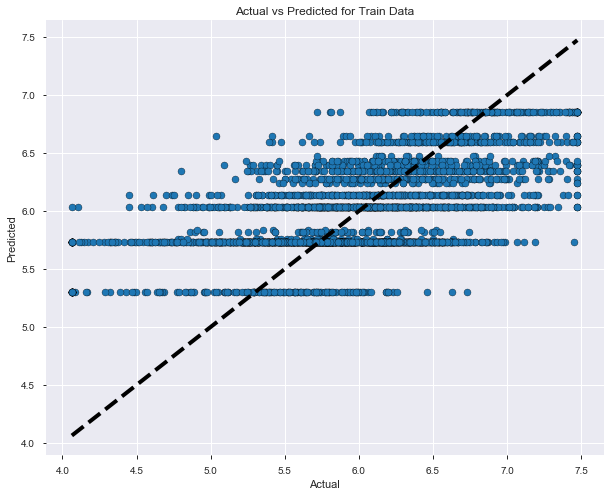

In [98]:
fig, ax = plt.subplots()
ax.scatter(train_Y, treereg.predict(train_X), edgecolors = (0, 0, 0))
ax.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

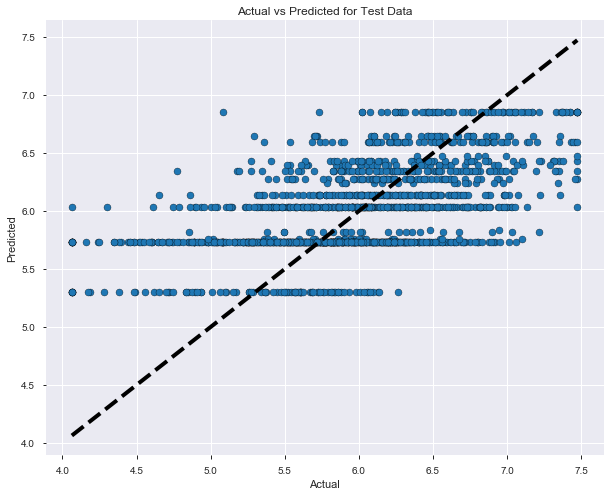

In [99]:
fig, ax = plt.subplots()
ax.scatter(test_Y, treereg.predict(test_X), edgecolors=(0, 0, 0))
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

## Random Forest (RF)

In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
RF = RandomForestRegressor(max_depth = 5, n_estimators = 20, random_state = 0)  
RF.fit(train_X, train_Y)  
y_pred = RF.predict(test_X) 

In [102]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, RF.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, RF.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, RF.predict(test_X))))

Mean Absolute Error: 0.42415197516806546
Mean Squared Error: 0.29052698004571387
Root Mean Squared Error: 0.539005547323693


In [103]:
print("R-squared for Train:",RF.score(train_X, train_Y))
print("R-squared for Test:",RF.score(test_X, test_Y))

R-squared for Train: 0.3670254642522407
R-squared for Test: 0.31148806339066715


In [104]:
pargrid_rf = {'n_estimators': (10, 50, 100), 'max_depth': range(3,6)}

In [105]:
gscv_rf = GridSearchCV(estimator = RandomForestRegressor(), 
                       param_grid = pargrid_rf, 
                       cv = 5, 
                       verbose = 0, 
                       n_jobs = -1)
    
gscv_result = gscv_rf.fit(train_X, train_Y)

In [106]:
gscv_result.best_params_

{'max_depth': 4, 'n_estimators': 100}

In [107]:
gscv_rf.best_score_

0.29780478779479846

### Final Random Forest Model

In [108]:
RF = RandomForestRegressor(max_depth = 4, n_estimators = 100, random_state = 0, n_jobs = -1)  
RF.fit(train_X, train_Y)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [109]:
radm_test_pred = pd.DataFrame({ 'actual': test_Y, 'predicted': RF.predict(test_X)})

In [110]:
scores = cross_val_score(RF, train_X, train_Y, cv=15, scoring='r2')
scores

array([0.35929904, 0.21216492, 0.30977905, 0.38149385, 0.2754866 ,
       0.26832504, 0.31234545, 0.2634066 , 0.2508519 , 0.25938749,
       0.35283185, 0.24025676, 0.32330063, 0.34052134, 0.2754749 ])

In [111]:
np.mean(scores)

0.29499502966963936

In [112]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, RF.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, RF.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, RF.predict(test_X))))

Mean Absolute Error: 0.42274423477724765
Mean Squared Error: 0.28816836266341145
Root Mean Squared Error: 0.5368131543315714


In [113]:
print("R-squared for Train:" ,RF.score(train_X, train_Y))
print("R-squared for Test: ", RF.score(test_X, test_Y))

R-squared for Train: 0.3322813749087189
R-squared for Test:  0.31707768615600884


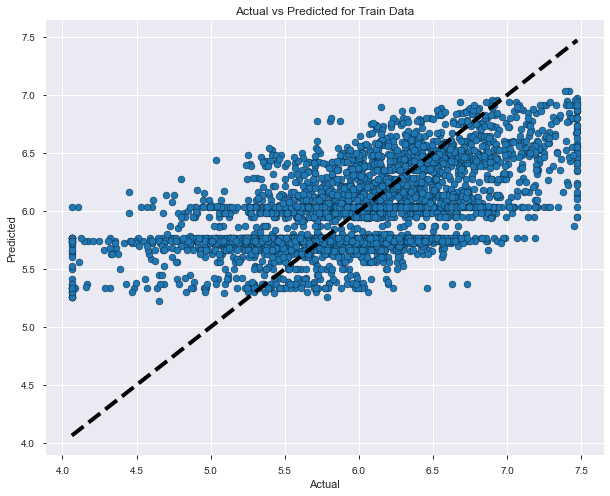

In [114]:
fig, ax = plt.subplots()
ax.scatter(train_Y, RF.predict(train_X), edgecolors = (0, 0, 0))
ax.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

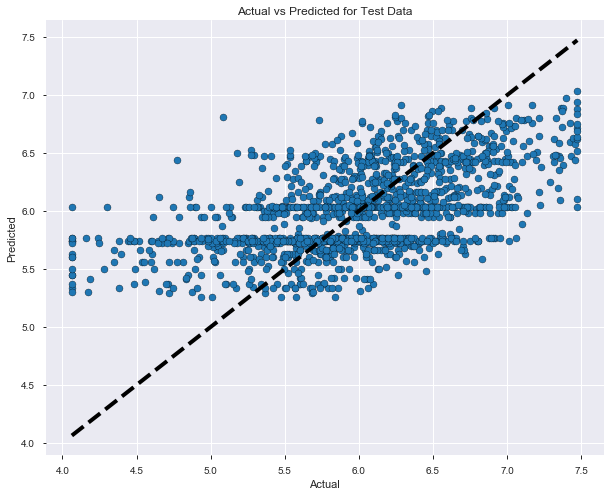

In [115]:
fig, ax = plt.subplots()
ax.scatter(test_Y, RF.predict(test_X) , edgecolors = (0, 0, 0))
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

## Gradient Boosting (GBM)

In [116]:
from sklearn.ensemble import GradientBoostingRegressor

In [117]:
GBMR = GradientBoostingRegressor()
GBMR.fit(train_X, train_Y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [118]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, GBMR.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, GBMR.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, GBMR.predict(test_X))))

Mean Absolute Error: 0.42290153399863845
Mean Squared Error: 0.28950962516472073
Root Mean Squared Error: 0.538060986473393


In [119]:
print("R-squared for Train:",GBMR.score(train_X, train_Y))
print("R-squared for Test:",GBMR.score(test_X, test_Y))

R-squared for Train: 0.4547569437197633
R-squared for Test: 0.3138990648722553


In [120]:
pargrid_gbmr = {'n_estimators': [50, 75, 100, 150],
               'learning_rate': [10 ** x for x in range(-2, 1)],
                'max_features': [13, 14, 15]}

In [121]:
gscv_gbmr = GridSearchCV(estimator = GradientBoostingRegressor(), 
                        param_grid = pargrid_gbmr, 
                        cv = 5,
                        verbose = True, n_jobs = -1)

In [122]:
gscv_result = gscv_gbmr.fit(train_X, train_Y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   21.2s finished


In [123]:
gscv_result.best_params_

{'learning_rate': 0.1, 'max_features': 15, 'n_estimators': 100}

In [124]:
gscv_result.best_score_

0.3071751926351249

### Final Gradient Boosting Model

In [129]:
gscv_gbmr = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 15)
gscv_gbmr.fit(train_X, train_Y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [130]:
scores = cross_val_score(gscv_gbmr, train_X, train_Y, cv = 10, scoring = 'r2')
scores

array([ 0.03614794,  0.0564435 , -0.0320229 ,  0.03504026, -0.03177506,
        0.00895572,  0.13364747, -0.08423561,  0.11764696,  0.08272229])

In [131]:
np.mean(scores)

0.032257056217799104

In [132]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, gscv_gbmr.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, gscv_gbmr.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, gscv_gbmr.predict(test_X))))

Mean Absolute Error: 0.4850151090883396
Mean Squared Error: 0.38082701227985855
Root Mean Squared Error: 0.6171118312590179


In [133]:
print("R-squared for Train:" ,gscv_gbmr.score(train_X, train_Y))
print("R-squared for Test: ", gscv_gbmr.score(test_X, test_Y))

R-squared for Train: 0.9999997566254063
R-squared for Test:  0.09748848903226037


### As we can see Gradient Boosting Model show over-fitting condition

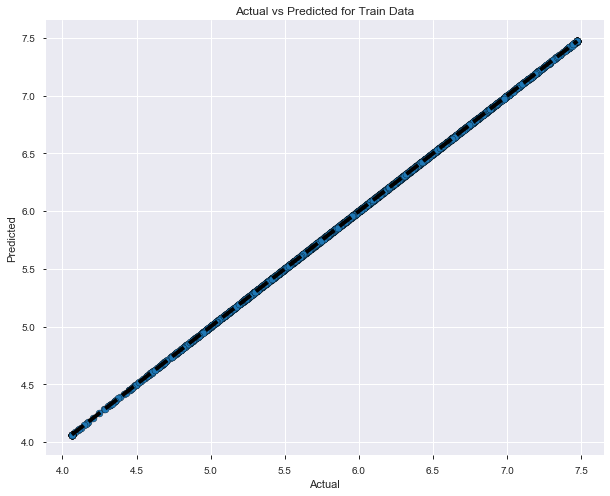

In [134]:
fig, ax = plt.subplots()
ax.scatter(train_Y,  gscv_gbmr.predict(train_X), edgecolors = (0, 0, 0))
ax.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

### we can see over-fitting problem from above plot also

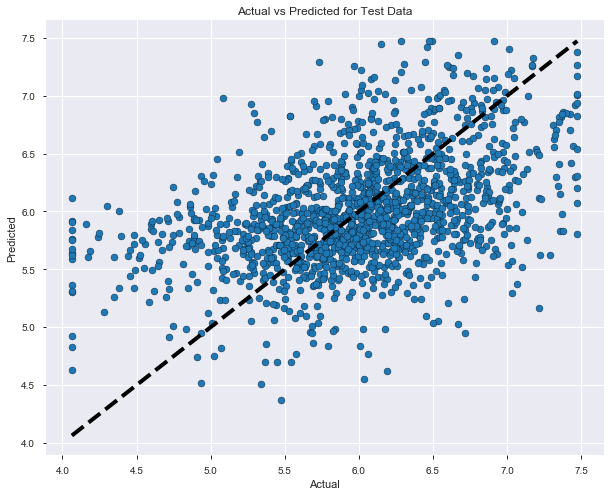

In [135]:
fig, ax = plt.subplots()
ax.scatter(test_Y, gscv_gbmr.predict(test_X), edgecolors=(0, 0, 0))
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

## XGBOOST

In [136]:
from xgboost import XGBRegressor

In [137]:
xgb = XGBRegressor(objective = 'reg:squarederror')
xgb.fit(train_X, train_Y)

C:\Users\rahul\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [138]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, xgb.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, xgb.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, xgb.predict(test_X))))

Mean Absolute Error: 0.42097873109708894
Mean Squared Error: 0.2857690450773554
Root Mean Squared Error: 0.5345737040646082


In [139]:
print("R-squared for Train:" ,xgb.score(train_X, train_Y))
print("R-squared for Test: ", xgb.score(test_X, test_Y))

R-squared for Train: 0.44641735097407115
R-squared for Test:  0.32276376322002653


In [140]:
xgb = XGBRegressor(objective = 'reg:squarederror')

In [141]:
para = {'n_estimators': [50, 100, 150],
            'learning_rate': [0.03, 0.1, 0.2], 
            'max_depth': [2, 3, 4]}

In [142]:
xgb_grid = GridSearchCV(xgb, para, cv = 2, n_jobs = -1, verbose = True)
grid_result = xgb_grid.fit(train_X, train_Y)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   47.7s finished
C:\Users\rahul\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [143]:
xgb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

In [144]:
xgb_grid.best_score_

0.3014383682242706

### Final XGBoost Model

In [145]:
xgb = XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 2,objective = 'reg:squarederror')
xgb.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [146]:
scores = cross_val_score(xgb, train_X, train_Y, cv=10, scoring='r2')
scores

C:\Users\rahul\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rahul\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rahul\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rahul\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rahul\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rahul\Anaco

array([0.30280374, 0.31900459, 0.33118707, 0.32676515, 0.30317634,
       0.26555257, 0.3213238 , 0.27522619, 0.34471845, 0.32898566])

In [147]:
np.mean(scores)

0.3118743581642336

In [148]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, xgb.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, xgb.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, xgb.predict(test_X))))

Mean Absolute Error: 0.4194537832925636
Mean Squared Error: 0.2846889674551037
Root Mean Squared Error: 0.5335625244103109


In [149]:
print("R-squared for Train:" ,xgb.score(train_X, train_Y))
print("R-squared for Test: ", xgb.score(test_X, test_Y))

R-squared for Train: 0.37310287524012276
R-squared for Test:  0.3253234096090398


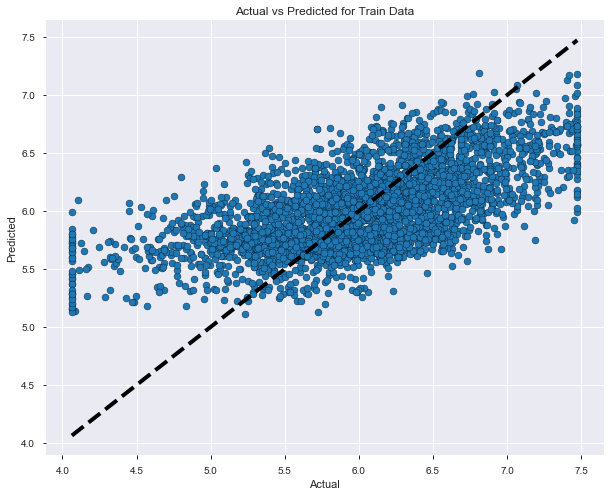

In [150]:
fig, ax = plt.subplots()
ax.scatter(train_Y, xgb.predict(train_X), edgecolors = (0, 0, 0))
ax.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

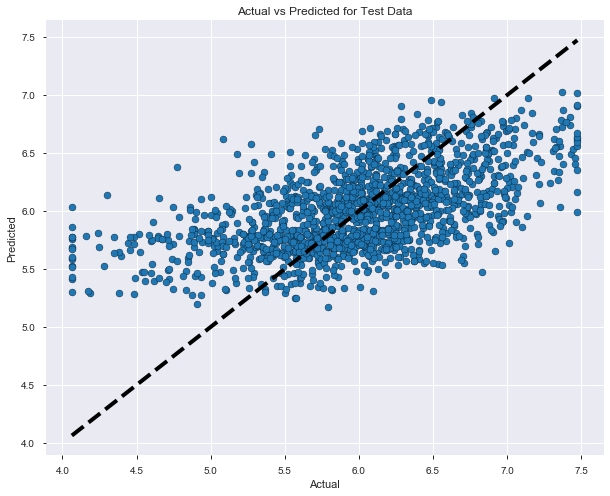

In [151]:
fig, ax = plt.subplots()
ax.scatter(test_Y, xgb.predict(test_X), edgecolors = (0, 0, 0))
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

## Support Vector Regression (SVR)

In [152]:
from sklearn.svm import SVR

In [153]:
svr = SVR(gamma = 'scale')
svr.fit(train_X, train_Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [154]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, svr.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, svr.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, svr.predict(test_X))))

Mean Absolute Error: 0.4878800242168746
Mean Squared Error: 0.3942454049291035
Root Mean Squared Error: 0.6278896439097427


In [155]:
print("R-squared for Train:",svr.score(train_X, train_Y))
print("R-squared for Test:",svr.score(test_X, test_Y))

R-squared for Train: 0.12422100124688383
R-squared for Test: 0.06568860763170203


In [156]:
svr = SVR()

In [157]:
para = {'C' : [1, 10, 100,150],
              'gamma': [10 ** x for x in range(-10, -5)],
              'epsilon':[0.1,0.5]}

In [158]:
svr = GridSearchCV(svr ,para, cv = 5)
grid_result = svr.fit(train_X, train_Y)

In [159]:
svr.best_params_

{'C': 100, 'epsilon': 0.1, 'gamma': 1e-08}

In [160]:
svr.best_score_

0.1272296540621322

 ### Final Support Vector Regression (SVR)

In [161]:
svr = SVR(C = 100, gamma = 1e-08, epsilon = 0.1)
svr.fit(train_X, train_Y)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-08,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [162]:
score = cross_val_score(svr, train_X, train_Y, cv = 10, scoring = 'r2')
score

array([0.09298945, 0.10173705, 0.15249732, 0.11995936, 0.12615268,
       0.16267802, 0.11673479, 0.12453797, 0.13175748, 0.1630182 ])

In [163]:
np.mean(score)

0.1292062315665024

In [164]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, svr.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, svr.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, svr.predict(test_X))))

Mean Absolute Error: 0.475382893678781
Mean Squared Error: 0.3743621378636618
Root Mean Squared Error: 0.611851401782869


In [165]:
print("R-squared for Train:" ,svr.score(train_X, train_Y))
print("R-squared for Test: ", svr.score(test_X, test_Y))

R-squared for Train: 0.14787709087174117
R-squared for Test:  0.11280941793026279


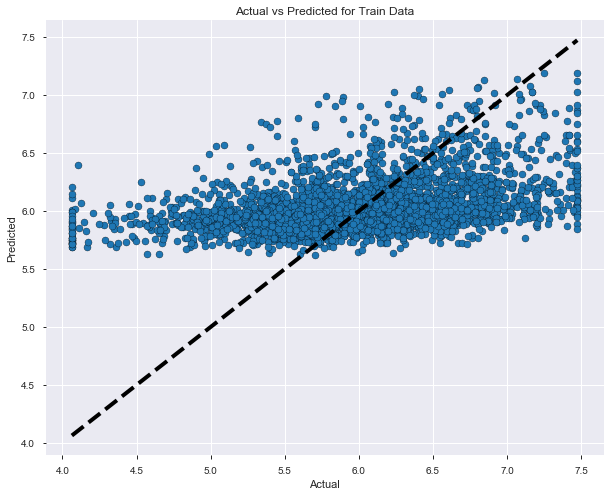

In [166]:
fig, ax = plt.subplots()
ax.scatter(train_Y, svr.predict(train_X), edgecolors = (0, 0, 0))
ax.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

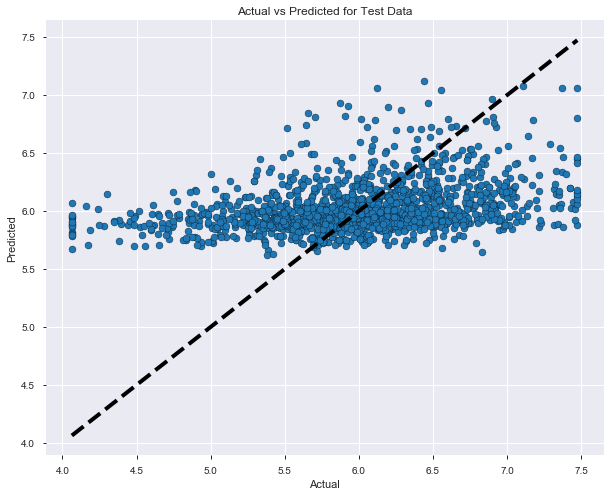

In [167]:
fig, ax = plt.subplots()
ax.scatter(test_Y, svr.predict(test_X), edgecolors=(0, 0, 0))
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

## K-Nearest Neighbor (KNN)

In [168]:
from sklearn.neighbors import KNeighborsRegressor

In [169]:
KNN = KNeighborsRegressor(n_neighbors = 5)
KNN.fit(train_X, train_Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [170]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, KNN.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, KNN.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, KNN.predict(test_X))))

Mean Absolute Error: 0.5589983098987221
Mean Squared Error: 0.49454540140262415
Root Mean Squared Error: 0.7032392206089079


In [171]:
print("R-squared for Train:",KNN.score(train_X, train_Y))
print("R-squared for Test:",KNN.score(test_X, test_Y))

R-squared for Train: 0.24430075603875845
R-squared for Test: -0.17200960822083888


In [172]:
rmse_val = []
rmse = []
for K in range(50,70):
    K = K + 1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(train_X, train_Y) 
    pred = model.predict(test_X) 
    error = np.sqrt(metrics.mean_squared_error(test_Y ,pred)) 
    rmse_val.append(error) 
    print('RMSE value for k = ' , K , 'is:', error)

RMSE value for k =  51 is: 0.6497803015709007
RMSE value for k =  52 is: 0.6501517270959112
RMSE value for k =  53 is: 0.6494671875423843
RMSE value for k =  54 is: 0.6495614598333523
RMSE value for k =  55 is: 0.6492885395915701
RMSE value for k =  56 is: 0.6493420399743475
RMSE value for k =  57 is: 0.6489552025516996
RMSE value for k =  58 is: 0.6490053742829217
RMSE value for k =  59 is: 0.6488892211314234
RMSE value for k =  60 is: 0.6487393317090383
RMSE value for k =  61 is: 0.6487657392878066
RMSE value for k =  62 is: 0.6484896891667995
RMSE value for k =  63 is: 0.6485518678177613
RMSE value for k =  64 is: 0.6486688925327386
RMSE value for k =  65 is: 0.6488768789899677
RMSE value for k =  66 is: 0.6488516692856435
RMSE value for k =  67 is: 0.6488771392192264
RMSE value for k =  68 is: 0.6483538421417161
RMSE value for k =  69 is: 0.6480472264047422
RMSE value for k =  70 is: 0.6481452825420453


In [173]:
min(rmse_val)

0.6480472264047422

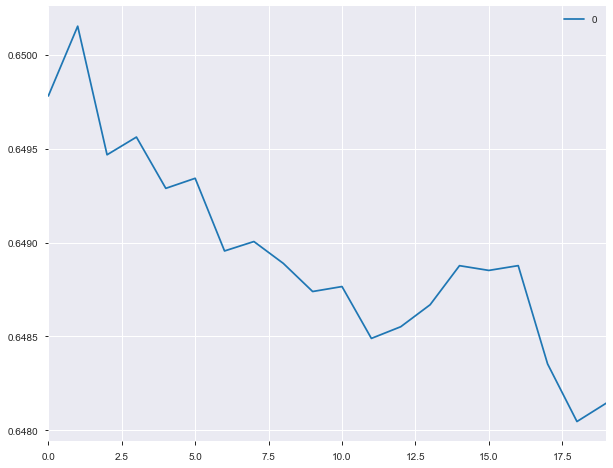

In [174]:
curve = pd.DataFrame(rmse_val) 
curve.plot()

### Final KNN Model

In [175]:
KNN = KNeighborsRegressor(n_neighbors = 69)
KNN.fit(train_X, train_Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=69, p=2,
                    weights='uniform')

In [176]:
scores = cross_val_score(KNN, train_X, train_Y, cv = 10, scoring = 'r2')
scores

array([-0.01059485,  0.01787213,  0.04309955,  0.03358955,  0.01286261,
        0.00853594,  0.01438286,  0.04261025,  0.00576076, -0.00929975])

In [177]:
np.mean(scores)

0.015881904807893067

In [178]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_Y, KNN.predict(test_X)))  
print('Mean Squared Error:', metrics.mean_squared_error(test_Y, KNN.predict(test_X)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_Y, KNN.predict(test_X))))

Mean Absolute Error: 0.5052697701649389
Mean Squared Error: 0.4199652076508792
Root Mean Squared Error: 0.6480472264047422


In [179]:
print("R-squared for Train:",KNN.score(train_X, train_Y))
print("R-squared for Test:",KNN.score(test_X, test_Y))

R-squared for Train: 0.043475909834522986
R-squared for Test: 0.004735951260877669


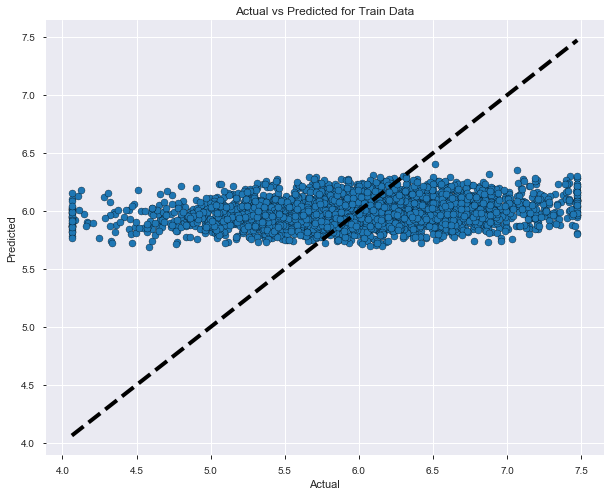

In [180]:
fig, ax = plt.subplots()
ax.scatter(train_Y, KNN.predict(train_X), edgecolors = (0, 0, 0))
ax.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

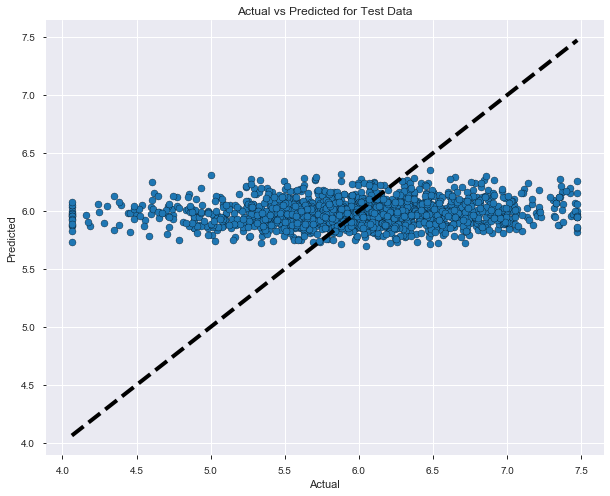

In [181]:
fig, ax = plt.subplots()
ax.scatter(test_Y, KNN.predict(test_X), edgecolors = (0, 0, 0))
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw = 4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()